In [1]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('loading_data_max.csv')
df=df.drop_duplicates()

X = df.drop(['filling_space_percent','density_percent'], axis=1)
y = df['filling_space_percent']
y

0      81.72327
1      51.56250
2      64.24381
3      67.29798
4      58.26317
         ...   
620    76.74275
622    83.18305
625     0.00248
626     0.00496
627     0.02481
Name: filling_space_percent, Length: 510, dtype: float64

In [3]:
X.shape

(510, 32)

In [4]:
# train-test split for model evaluation
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
#X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True,random_state=11)

# Standardizing data
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X)
#X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
 


In [5]:
# Define the model
model = nn.Sequential(
    nn.Linear(32, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 1)

)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0005)
 


In [7]:
n_epochs = 4000   # number of epochs to run
batch_size = 510  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_train)
    mse = loss_fn(y_pred, y_train)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | R^2_NNRegressor: {r2_score(y_train.detach().numpy(), y_pred.detach().numpy()):.4f} MSE:{mse:.4f}')


Epoch: 0 | R^2_NNRegressor: -4.4066 MSE:3191.2947
Epoch: 50 | R^2_NNRegressor: 0.0642 MSE:552.3658
Epoch: 100 | R^2_NNRegressor: 0.4770 MSE:308.6858
Epoch: 150 | R^2_NNRegressor: 0.7122 MSE:169.8795
Epoch: 200 | R^2_NNRegressor: 0.8104 MSE:111.9060
Epoch: 250 | R^2_NNRegressor: 0.8528 MSE:86.9127
Epoch: 300 | R^2_NNRegressor: 0.8693 MSE:77.1661
Epoch: 350 | R^2_NNRegressor: 0.8797 MSE:70.9931
Epoch: 400 | R^2_NNRegressor: 0.8882 MSE:66.0161
Epoch: 450 | R^2_NNRegressor: 0.8962 MSE:61.2921
Epoch: 500 | R^2_NNRegressor: 0.9041 MSE:56.6191
Epoch: 550 | R^2_NNRegressor: 0.9115 MSE:52.2670
Epoch: 600 | R^2_NNRegressor: 0.9180 MSE:48.4016
Epoch: 650 | R^2_NNRegressor: 0.9240 MSE:44.8444
Epoch: 700 | R^2_NNRegressor: 0.9298 MSE:41.4607
Epoch: 750 | R^2_NNRegressor: 0.9356 MSE:38.0296
Epoch: 800 | R^2_NNRegressor: 0.9416 MSE:34.4673
Epoch: 850 | R^2_NNRegressor: 0.9471 MSE:31.1978
Epoch: 900 | R^2_NNRegressor: 0.9529 MSE:27.8158
Epoch: 950 | R^2_NNRegressor: 0.9575 MSE:25.0798
Epoch: 1000 | R^

MSE: 0.26
RMSE: 0.51


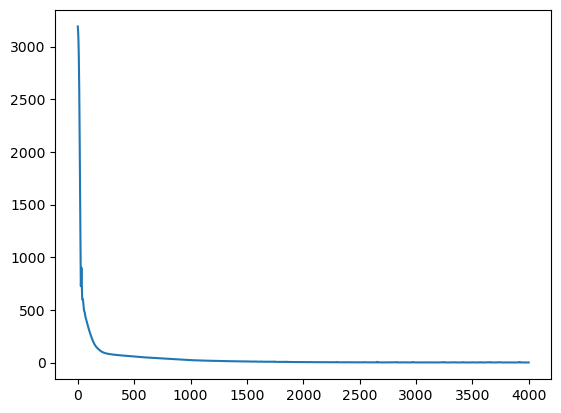

In [8]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [9]:
torch.save(model.state_dict(), 'NN_model_weights.pth')